# Bootstrapping simulations

We are interested in the extent to which hippocampal connectivity patterns are unique to the hippocampus rather than merely reflecting generic network structure in the brain. In this notebook, I will run two simulations. Here, I describe both:

1. Run 1000 iterations. In each iteration, first randomly sample 7 regions from the brain, and form a connectivity matrix from those 7 regions to the rest of the brain regions. Then, I will get the intersection between the regions that the random subsample connects to and those that the hippocampus connects to. As an example, imagine the hippocampal regions connect to regions C,D, and E, and that the random subsample connects to regions C,D,E, and F. In this case, the intersection is regions C,D, and E, and we drop column F. We then calculate correlation matrices for both the hippocampal connectivity matrix and the random sample connectivity matrices, and get the correlation between these two matrices. We save this correlation each iteration and average at the end of 1000 simulations.


3. In this simulation, we are interested in comparing how 7 random non-hippocampal regions connect to the set of regions that the hippocampus connects to, in the efferent condition, and how 7 random non-hippocampal regions recieve connections from the set of regions that project to the hippocampus, in the afferent condition. For example, imagine the hippocampus connects to regions W, X, Y, Z. We want to know what the "average" connectivity profile to regions W, X, Y, and Z will be. Same for afferent condition.
- Run 1000 iterations. In each iteration, first randomly sample 7 regions from the brain excluding hippocampal regions. In the efferent condition, form a connectivity matrix between the randomly sampled regions and the set of regions that hippocampus projects to. In the afferent condition, form a connectivity matrix between the randomly sampled regions and the set of regions that hippocampus receives input from. Calculate the correlation matrices from both of these matrices. We average these correlation matrices over 1000 simulations, ignoring the iteration if it results in a NaN value for a given region.

## Simulation 1

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from scipy.stats import spearmanr, pearsonr

from sklearn.manifold import TSNE
from sklearn.manifold import MDS

In [2]:
df_average = pd.read_csv('../output/average_connectome_data.csv', header=0, index_col=0)

In [3]:
# define hippocampal subregions - updated on Mar. 5
hippocampal_regions = np.array(['DG','CA3','CA2','CA1v','CA1d','SUBv','SUBd'])

# FROM hippocampus
df_avg_from = df_average[df_average.index.isin(hippocampal_regions)]
df_avg_from = df_avg_from.drop(hippocampal_regions, axis=1) # drop hpc regions from columms

# TO hippocampus
df_average_t = df_average.T
df_avg_to = df_average_t[df_average_t.index.isin(hippocampal_regions)]
df_avg_to = df_avg_to.drop(hippocampal_regions, axis=1) # drop hpc regions from columms

# filter to only include columns and rows with at least one connection
df_avg_from = df_avg_from.loc[:,df_avg_from.apply(np.count_nonzero, axis=0) >= 1]
df_avg_to = df_avg_to.loc[:,df_avg_to.apply(np.count_nonzero, axis=0) >= 1]

# probably want to drop na columns and rows of all NaNs
spearman_df_from_hpc = (df_avg_from.corr(method='spearman').dropna(axis=0, how='all')).dropna(axis=1, how='all')
spearman_df_to_hpc = (df_avg_to.corr(method='spearman').dropna(axis=0, how='all')).dropna(axis=1, how='all')

In [13]:
num_sims = 1000

correlation_afferent_arr = np.zeros(num_sims, dtype=float)
correlation_efferent_arr = np.zeros(num_sims, dtype=float)

for i in range(1000):
    # Subsample size
    k = 7
    
    # Random subsample without replacement
    subsample = np.random.choice(df_average.index, size=k, replace=False)

    # construct afferent / efferent connection matrices from random regions
    # FROM random
    df_avg_from_random_sample = df_average[df_average.index.isin(subsample)]
    
    # TO random
    df_average_t = df_average.T
    df_avg_to_random_sample = df_average_t[df_average_t.index.isin(subsample)]
    
    # probably want to drop na columns and rows of all NaNs
    spearman_df_from_random_sample = (df_avg_from_random_sample.corr(method='spearman').dropna(axis=0, how='all')).dropna(axis=1, how='all')
    spearman_df_to_random_sample = (df_avg_to_random_sample.corr(method='spearman').dropna(axis=0, how='all')).dropna(axis=1, how='all')
    
    common_indices_from = spearman_df_from_hpc.index.intersection(spearman_df_from_random_sample.index)
    common_indices_to = spearman_df_to_hpc.index.intersection(spearman_df_to_random_sample.index)
    
    # efferent
    rsa_spearman_aligned_from_hpc = spearman_df_from_hpc.loc[common_indices_from, common_indices_from]
    rsa_spearman_aligned_from_random_sample = spearman_df_from_random_sample.loc[common_indices_from, common_indices_from]
    
    # afferent
    rsa_spearman_aligned_to_hpc = spearman_df_to_hpc.loc[common_indices_to, common_indices_to]
    rsa_spearman_aligned_to_random_sample = spearman_df_to_random_sample.loc[common_indices_to, common_indices_to]

    flat_from_hpc = rsa_spearman_aligned_from_hpc.to_numpy().flatten()
    flat_from_random_sample = rsa_spearman_aligned_from_random_sample.to_numpy().flatten()
    
    flat_to_hpc = rsa_spearman_aligned_to_hpc.to_numpy().flatten()
    flat_to_random_sample = rsa_spearman_aligned_to_random_sample.to_numpy().flatten()

    # get correlation values
    correlation_afferent, p_aff = pearsonr(flat_to_hpc, flat_to_random_sample)
    correlation_efferent, p_eff = pearsonr(flat_from_hpc, flat_from_random_sample)

    correlation_afferent_arr[i] = correlation_afferent
    correlation_efferent_arr[i] = correlation_efferent
    

In [14]:
mean_corr_eff = np.mean(correlation_efferent_arr)
mean_corr_aff = np.mean(correlation_afferent_arr)

In [15]:
mean_corr_eff

0.19174172028385147

In [16]:
mean_corr_aff

0.22423988158381736

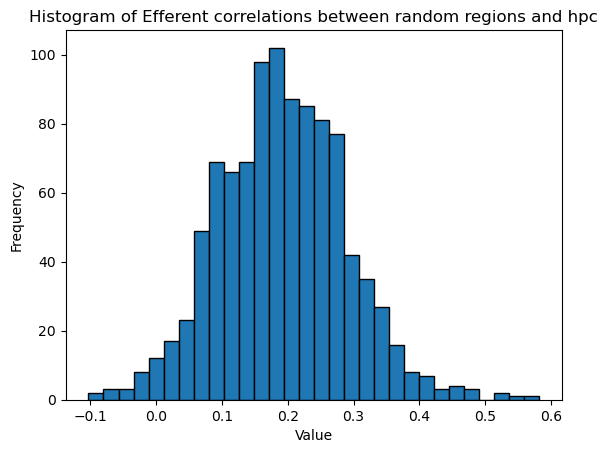

In [17]:
# Plot histogram
plt.hist(correlation_efferent_arr, bins=30, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Efferent correlations between random regions and hpc')
plt.show()

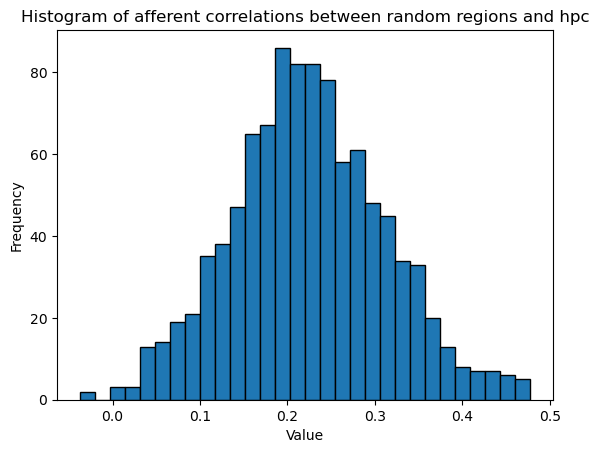

In [18]:
# Plot histogram
plt.hist(correlation_afferent_arr, bins=30, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of afferent correlations between random regions and hpc')
plt.show()

## Simulation 2

In [26]:
# Assuming your inputs are:
# connectivity_matrix: numpy array of shape (392, 392)
# hippocampal_indices: list or array of 7 indices for hippocampal regions
# target_cols: list or array of 162 indices of the target regions (columns)

def bootstrap_correlations(connectivity_matrix, hippocampal_indices, target_cols, n_iterations=1000):
    # this should be set to connectivity_matrix shape[0]
    n_regions = df_average.shape[0]
    n_targets = len(target_cols)

    sum_matrix = pd.DataFrame(0.0, index=target_cols, columns=target_cols)
    count_matrix = pd.DataFrame(0, index=target_cols, columns=target_cols)
    
    mask = np.isin(connectivity_matrix.index, hippocampal_regions, invert=True)
    non_hippocampal_regions = connectivity_matrix.index[mask]

    for i in range(n_iterations):
        # Randomly sample 7 non-hippocampal regions
        sampled_rows = np.random.choice(non_hippocampal_regions, size=7, replace=False)

        # Extract the 7x162 matrix
        sampled_matrix = connectivity_matrix.loc[sampled_rows, target_cols]

        # compute correlation
        corr_matrix = sampled_matrix.corr(method='spearman')

        

        # fill out the correlation matrix for current iteration
        # fill out mask matrix for current iteration
        full_corr = pd.DataFrame(0.0, index=target_cols, columns=target_cols)
        full_mask = pd.DataFrame(0, index=target_cols, columns=target_cols)
        
        for row_index, region_row in enumerate(target_cols):
            for col_index, region_col in enumerate(target_cols):
                if(not pd.isna(corr_matrix.loc[region_row,region_col])):
                    full_corr.loc[region_row, region_col] = corr_matrix.loc[region_row,region_col]
                    full_mask.loc[region_row, region_col] = 1

        # lastly, we control for if any of the sample regions are in the target cols.
        # If they are, we want to set the rows and columns for that sample region in corr matrix set to 0,
        # and set mask for 0 (just don't add this iteration in the correlation matrix for that region)
        sample_regions_in_target = target_cols.intersection(sampled_rows)

        for sample_region in sample_regions_in_target:
            # set rows in correlation to 0
            full_corr.loc[sample_region, :] = 0
            full_corr.loc[:, sample_region] = 0

            # set rows in mask to 0
            full_mask.loc[sample_region, :] = 0
            full_mask.loc[:, sample_region] = 0
        
        # Update accumulators
        sum_matrix = sum_matrix + full_corr
        count_matrix = count_matrix + full_mask

    average_matrix = sum_matrix / count_matrix
    return average_matrix, count_matrix

In [27]:
avg_corr_matrix_efferent, counts_efferent = bootstrap_correlations(connectivity_matrix = df_average, 
                                                 hippocampal_indices=hippocampal_regions, 
                                                 target_cols=spearman_df_from_hpc.index,
                                                 n_iterations=1000)

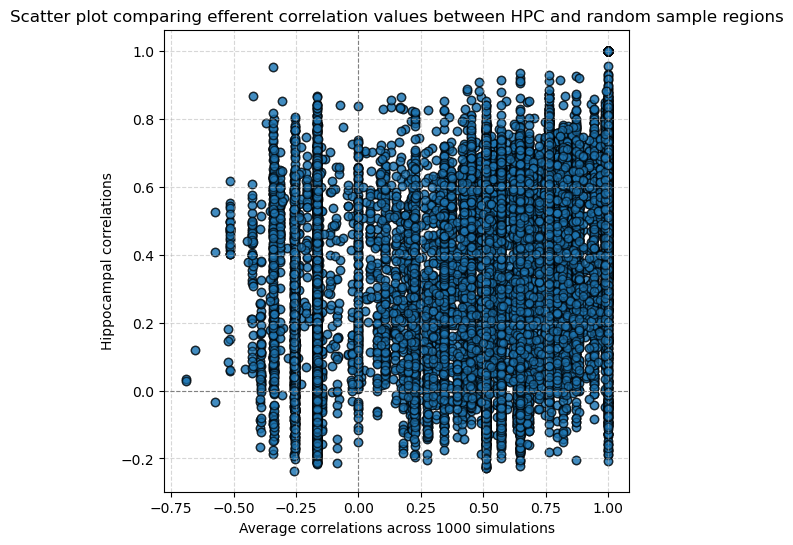

In [28]:
# Flatten matrices to get corresponding values
x_values = spearman_df_from_hpc.to_numpy().flatten()  
y_values = avg_corr_matrix_efferent.to_numpy().flatten()

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(x_values, y_values, alpha=0.6, edgecolor="k")
plt.xlabel("Average correlations across 1000 simulations")
plt.ylabel("Hippocampal correlations")
plt.title("Scatter plot comparing efferent correlation values between HPC and random sample regions")
plt.axhline(y=0, color="gray", linestyle="--", linewidth=0.8)
plt.axvline(x=0, color="gray", linestyle="--", linewidth=0.8)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [29]:
avg_corr_matrix_afferent, counts_afferent = bootstrap_correlations(connectivity_matrix = df_average, 
                                                 hippocampal_indices=hippocampal_regions, 
                                                 target_cols=spearman_df_to_hpc.index,
                                                 n_iterations=1000)

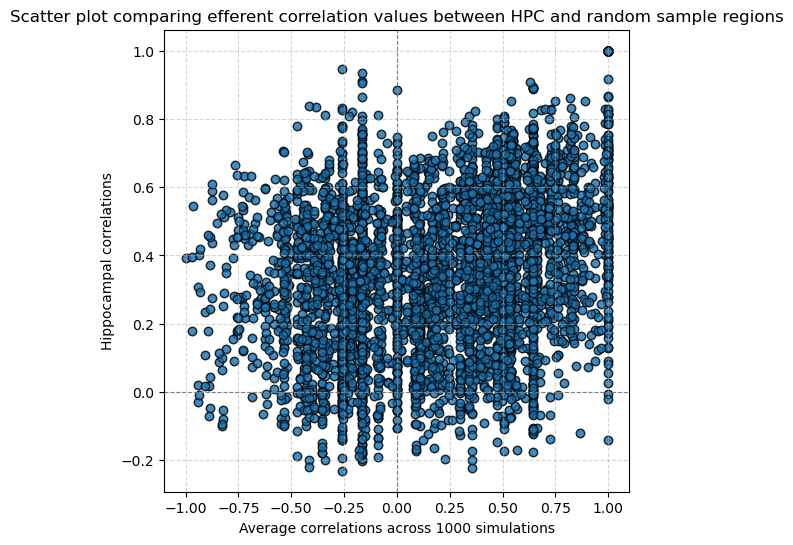

In [30]:
# Flatten matrices to get corresponding values
x_values = spearman_df_to_hpc.to_numpy().flatten()  
y_values = avg_corr_matrix_afferent.to_numpy().flatten()

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(x_values, y_values, alpha=0.6, edgecolor="k")
plt.xlabel("Average correlations across 1000 simulations")
plt.ylabel("Hippocampal correlations")
plt.title("Scatter plot comparing efferent correlation values between HPC and random sample regions")
plt.axhline(y=0, color="gray", linestyle="--", linewidth=0.8)
plt.axvline(x=0, color="gray", linestyle="--", linewidth=0.8)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [ ]:
# compute the pearson correlations
# efferent
from scipy.stats import spearmanr, pearsonr

hpc_corr_flat_efferent = spearman_df_from_hpc.to_numpy().flatten()
random_samples_corr_flat_efferent = avg_corr_matrix_efferent.to_numpy().flatten()

correlation_efferent, p_value = pearsonr(hpc_corr_flat, random_samples_corr_flat)

print(correlation_efferent, p_value)

In [31]:
print(avg_corr_matrix_efferent, avg_corr_matrix_afferent)

             SI        MS       NDB       TRS     BSTam     BSTfu      BSTv  \
SI     1.000000  0.486182  0.567059  0.392755  0.642190  0.543244  0.614774   
MS     0.486182  1.000000  0.739714  0.641019  0.525635  0.333488  0.499783   
NDB    0.567059  0.739714  1.000000  0.627101  0.543497  0.398513  0.497717   
TRS    0.392755  0.641019  0.627101  1.000000  0.414567  0.081187  0.462817   
BSTam  0.642190  0.525635  0.543497  0.414567  1.000000  0.650917  0.849024   
...         ...       ...       ...       ...       ...       ...       ...   
VTA    0.590202  0.420183  0.509167  0.378665  0.408419  0.462552  0.404977   
PRC    0.476757  0.533705  0.498648  0.462667  0.487273  0.390532  0.511555   
COM    0.474447  0.417656  0.399929  0.283075  0.493076  0.415857  0.528348   
PAGrn  0.498661  0.559433  0.547236  0.474124  0.529966  0.418629  0.595051   
DTN    0.139828  0.198104  0.237368  0.100070  0.038506  0.199371 -0.034770   

          BSTmg     BSTdm     BSTal  ...        AV 